<a href="https://colab.research.google.com/github/dainilliniad/small311qlab/blob/neurowave/%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import numpy as np
import torch #
import torchvision #
import matplotlib.pyplot as plt #
from time import time #
from torchvision import datasets, transforms #
from google.colab import drive #
from torch.utils.data import Dataset #
from torch.utils.data import DataLoader #
from tqdm import tqdm #
from torch.autograd import Variable #
import torch.nn as nn #
from torch import tensor
import random
import matplotlib
drive.mount('/content/gdrive')
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_random_seed(42)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
correlation1=np.load('/content/cor1.npy') #тут указать свой путь до
correlation2=np.load('/content/cor2.npy')
correlation3=np.load('/content/cor3.npy')
pitog=np.load('/content/pitog.npy')
tetta=np.load('/content/tetitog.npy')   #файлов numpy, созданных в первой части проекта

In [16]:
class LAADataset(Dataset): #создание датасетов из наших файлов
    def __init__(self, Corr_data_g1, Corr_data_g2, Corr_data_g3, Theta_data, P_data, x_0, x_end):
      self.LAAdata = []
      self.len_data = x_end-x_0
      for obj in tqdm(range(self.len_data)):
        self.LAAdata.append((tensor([Corr_data_g1[obj],Corr_data_g2[obj],Corr_data_g3[obj]]),tensor([(Theta_data[obj]+np.exp(1)/2)/np.exp(1),P_data[obj]/0.9])))

    def __len__(self):
      return self.len_data

    def __getitem__(self, idx):
      return self.LAAdata[idx][0],self.LAAdata[idx][1]

In [31]:
set_random_seed(42)
#объявление модели, число нейронов в слоях
model = torch.nn.Sequential(
        torch.nn.Linear(3, 50, bias=False),
        nn.BatchNorm1d(50),
        torch.nn.ReLU(),

        torch.nn.Linear(50, 200, bias=False),
        nn.BatchNorm1d(200),
        torch.nn.ReLU(),

        torch.nn.Linear(200, 600, bias=False),
        nn.BatchNorm1d(600),
        torch.nn.ReLU(),

        torch.nn.Linear(600, 200, bias=False),
        nn.BatchNorm1d(200),
        torch.nn.ReLU(),

        torch.nn.Linear(200, 100, bias=False),
        nn.BatchNorm1d(100),
        torch.nn.ReLU(),

        torch.nn.Linear(100, 25, bias=False),
        nn.BatchNorm1d(25),
        torch.nn.ReLU(),

        torch.nn.Linear(25, 2),
        torch.nn.Sigmoid()
        )

In [34]:
set_random_seed(42)
# Длина обучающей и тестирующей выборок
lenTestData = 1000 #длина тестовой выборки
lenTrainData = 14500 #длина обучающей выборки
batch_size = 250 #размер батча
epoches=15 #чило эпох
criterion = torch.nn.MSELoss() #критерий оптимизации ошибки - среднеквадратический
optimizer = torch.optim.Adam(model.parameters(), lr=(1e-5)*5)  #шаг спуска - 10^-4

testDatasets = LAADataset(correlation1,correlation2, correlation3, tetta, pitog, 0,lenTestData)
trainDatasets = LAADataset(correlation1,correlation2, correlation3, tetta, pitog,lenTestData,lenTrainData+lenTestData)

testDataloader = DataLoader(testDatasets, batch_size=batch_size, shuffle=False, num_workers=2)
trainDataloader = DataLoader(trainDatasets, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 14500/14500 [00:00<00:00, 51027.52it/s]


In [35]:
set_random_seed(42)
#обучение модели по эпохам
model = model.float()
loss_train = []
loss_test = []
loss_train_tet = []
loss_test_tet = []
loss_train_p = []
loss_test_p = []

for epoch in range(epoches):
  model.train()
  for corf, tettab in trainDataloader:

    tettab = tettab.float()
    output = model(corf.float()) #получаем результат
    loss = criterion(output, tettab)  #считаем ошибку по критерию
    loss_tetta=criterion(output[0], tettab[0]) #считаем ошибку тетта по критерию
    loss_p=criterion(output[1], tettab[1]) #считаем ошибку p по критерию

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_train.append(loss.item())
  loss_train_tet.append(loss_tetta.item())
  loss_train_p.append(loss_p.item())

  model.eval()
  for corf, tettab in testDataloader:  #тоже самое, только для тестовой выборки
    tettab = tettab.float()
    output = model(corf.float())
    loss = criterion(output, tettab)
    loss_tetta=criterion(output[0], tettab[0])
    loss_p=criterion(output[1], tettab[1])

  loss_test.append(loss.item())
  loss_test_tet.append(loss_tetta.item())
  loss_test_p.append(loss_p.item())
  print('Epoch: ', epoch, 'Loss: ', loss.item())

Epoch:  0 Loss:  0.017155161127448082
Epoch:  1 Loss:  0.012541921809315681
Epoch:  2 Loss:  0.01082876231521368
Epoch:  3 Loss:  0.009642298333346844
Epoch:  4 Loss:  0.009387546218931675
Epoch:  5 Loss:  0.008612828329205513
Epoch:  6 Loss:  0.00802905485033989
Epoch:  7 Loss:  0.008017290383577347
Epoch:  8 Loss:  0.007909061387181282
Epoch:  9 Loss:  0.007426255848258734
Epoch:  10 Loss:  0.007124850060790777
Epoch:  11 Loss:  0.0068319328129291534
Epoch:  12 Loss:  0.006739370990544558
Epoch:  13 Loss:  0.0062203118577599525
Epoch:  14 Loss:  0.006324303336441517


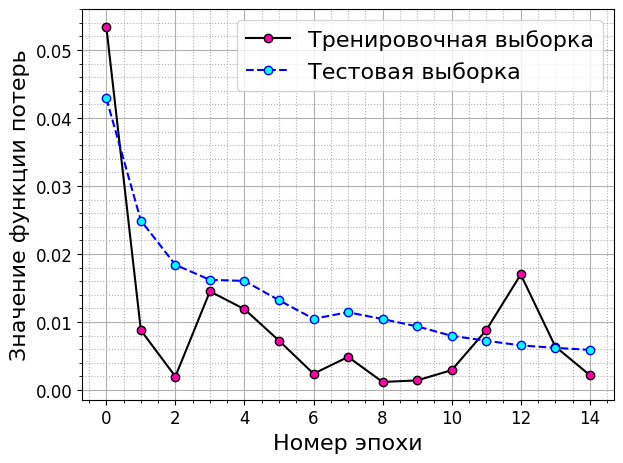

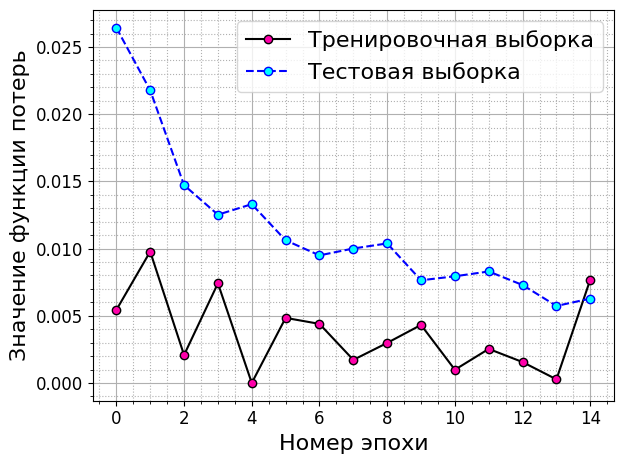

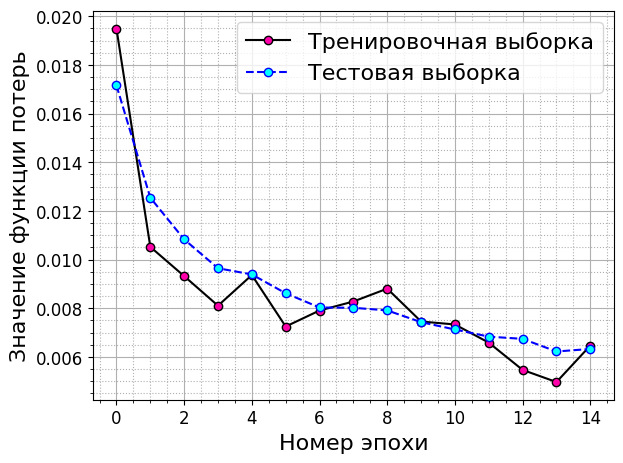

In [36]:
def plotLoss(localtest, localtrain, name):
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtrain, linestyle='-', marker='o', color='k',
         markerfacecolor='#ff00aaff', label='Тренировочная выборка')
  ax.plot(localtest, linestyle='--', marker='o', color='b',
         markerfacecolor='#00ffffff',  label='Тестовая выборка')
  ax.legend(fontsize=16)
  ax.minorticks_on()
  ax.set_xlabel('Номер эпохи', fontsize=16)
  ax.set_ylabel(r'Значение функции потерь', fontsize=16)
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  fig.show()

plotLoss(loss_test_p,loss_train_p,'loss')
plotLoss(loss_test_tet,loss_train_tet,'loss')
plotLoss(loss_test,loss_train,'loss')

<ipython-input-42-193a9d0e45d5>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tet=torch.tensor((tet*np.exp(1))-np.exp(1)/2*torch.ones(7,7))  #переводим в тензоры


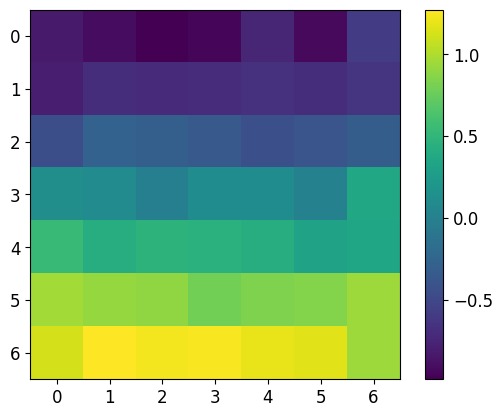

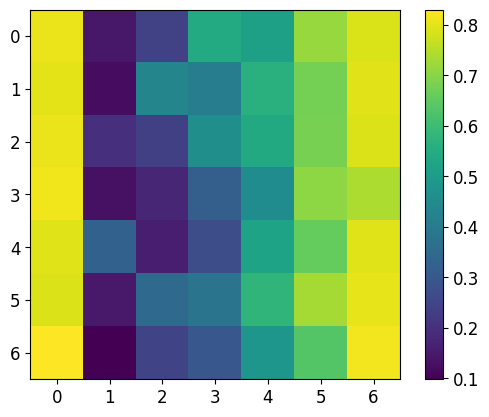

tensor([[-0.8263, -0.9111, -0.9863, -0.9490, -0.7462, -0.9310, -0.5949],
        [-0.7925, -0.6931, -0.7099, -0.6987, -0.6680, -0.6875, -0.6451],
        [-0.4433, -0.2787, -0.3067, -0.3527, -0.4306, -0.3889, -0.3207],
        [ 0.1308,  0.1006, -0.0120,  0.1083,  0.1096,  0.0047,  0.3673],
        [ 0.5324,  0.4216,  0.4710,  0.4564,  0.4221,  0.3159,  0.3453],
        [ 0.9566,  0.9151,  0.8948,  0.7888,  0.8363,  0.8495,  0.9378],
        [ 1.1245,  1.2726,  1.2347,  1.2471,  1.1937,  1.1717,  0.9379]])
tensor([[0.8089, 0.1441, 0.2400, 0.5453, 0.5142, 0.7156, 0.7881],
        [0.8000, 0.1219, 0.4302, 0.4091, 0.5629, 0.6755, 0.7955],
        [0.8075, 0.1980, 0.2363, 0.4627, 0.5413, 0.6783, 0.7900],
        [0.8128, 0.1317, 0.1755, 0.3185, 0.4552, 0.7067, 0.7397],
        [0.7943, 0.3249, 0.1585, 0.2713, 0.5238, 0.6570, 0.7940],
        [0.7912, 0.1473, 0.3478, 0.3788, 0.5767, 0.7306, 0.8013],
        [0.8296, 0.0982, 0.2472, 0.2973, 0.4828, 0.6328, 0.8170]])


In [42]:
length=7  #длина изображение, примем 7, длина равна ширине
width=length   #ширина изображение, примем квадратным, длина равна ширине
x=[[0.1906, 0.0296, 0.0240, 0.0896, 0.0710, 0.1354, 0.1691],
        [0.1917, 0.0992, 0.1224, 0.1307, 0.1598, 0.1774, 0.2019],
        [0.2321, 0.2191, 0.2354, 0.2165, 0.2050, 0.2106, 0.2220],
        [0.2771, 0.2367, 0.2595, 0.2516, 0.2516, 0.2641, 0.2249],
        [0.2360, 0.2237, 0.1946, 0.2062, 0.2317, 0.2341, 0.2557],
        [0.1917, 0.0934, 0.1125, 0.1358, 0.1563, 0.1861, 0.1992],
        [0.1869, 0.0074, 0.0398, 0.0446, 0.0846, 0.1206, 0.1897]]
y=[[0.1926, 0.0488, 0.0891, 0.1133, 0.1427, 0.1627, 0.2021],
        [0.1808, 0.0014, 0.0554, 0.0418, 0.0849, 0.1199, 0.1706],
        [0.1779, 0.0481, 0.0282, 0.0639, 0.0788, 0.1326, 0.1869],
        [0.2257, 0.1394, 0.1057, 0.1453, 0.1545, 0.1804, 0.2243],
        [0.2586, 0.2278, 0.2173, 0.2212, 0.2429, 0.2256, 0.2394],
        [0.2326, 0.2442, 0.2652, 0.2624, 0.2365, 0.2659, 0.2619],
        [0.2327, 0.1763, 0.1895, 0.2000, 0.2288, 0.2071, 0.2235]]
z=[[ 0.2287,  0.2293,  0.2514,  0.2512,  0.2370,  0.2317,  0.2504],
        [ 0.2233,  0.1429,  0.1646,  0.1723,  0.1697,  0.1948,  0.2078],
        [ 0.1983,  0.0413,  0.0611,  0.0970,  0.1273,  0.1431,  0.1807],
        [ 0.1818, -0.0090,  0.0061,  0.0310,  0.0539,  0.1319,  0.1637],
        [ 0.1847,  0.0653,  0.0451,  0.0673,  0.0977,  0.1324,  0.1755],
        [ 0.2148,  0.1470,  0.1780,  0.1564,  0.1775,  0.1981,  0.2212],
        [ 0.2509,  0.2331,  0.2287,  0.2361,  0.2288,  0.2282,  0.2514]]
#x, y, z - 3 корреляционные функции g1, g2, g3 которые тестируем на сетке
t=[]
for i in range(length):
  for j in range(width):
    t.append([x[i][j], y[i][j], z[i][j]])

model1=model(torch.tensor(t))
p=[]
tet=[]
p1=[]
tet1=[]
for i in range(length*width):
  if len(p1)!=length:
     p1.append(float(model1[i][1]))
     tet1.append(float(model1[i][0]))
  else:
    p.append(p1)
    tet.append(tet1)
    p1=[]
    tet1=[]
    p1.append(float(model1[i][1]))
    tet1.append(float(model1[i][0]))
p.append(p1)
tet.append(tet1)

p=torch.tensor(p)*0.9  #переводим в тензоры
tet=torch.tensor(tet)
tet=torch.tensor((tet*np.exp(1))-np.exp(1)/2*torch.ones(7,7))  #переводим в тензоры

plt.imshow(tet)
plt.colorbar()
plt.show()
plt.imshow(p)
plt.colorbar()
plt.show()
print(tet)
print(p)